In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 0) 데이터 불러오기

In [ ]:
all_cluster= pd.read_csv("/content/drive/MyDrive/kdt-data-33/DS_DE_33/pjt-1/dacon-raw-data/dacon_dataset.csv")

In [ ]:
all_merge= pd.read_csv("/content/drive/MyDrive/kdt-data-33/DS_DE_33/pjt-1/dacon-raw-data/all_merge.csv")
all_merge.head(3)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,기준연월,월,성별,고객지역,GST,쿠폰코드,할인율
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,2019-01,1,남,Chicago,0.1,ELEC10,10.0
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,2019-01,1,남,Chicago,0.1,ELEC10,10.0
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,2019-01,1,남,Chicago,0.1,OFF10,10.0


# 1) 기본 데이터 체크

## 1-1) Null 값 확인

In [ ]:
all_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   고객ID    52924 non-null  object 
 1   거래ID    52924 non-null  object 
 2   거래날짜    52924 non-null  object 
 3   제품ID    52924 non-null  object 
 4   제품카테고리  52924 non-null  object 
 5   수량      52924 non-null  int64  
 6   평균금액    52924 non-null  float64
 7   배송료     52924 non-null  float64
 8   쿠폰상태    52924 non-null  object 
 9   기준연월    52924 non-null  object 
 10  월       52924 non-null  int64  
 11  성별      52924 non-null  object 
 12  고객지역    52924 non-null  object 
 13  GST     52924 non-null  float64
 14  쿠폰코드    52524 non-null  object 
 15  할인율     52524 non-null  float64
dtypes: float64(4), int64(2), object(10)
memory usage: 6.5+ MB


- 쿠폰코드, 할인율에 약 400개의 null 값이 존재하는 걸 확인.
- 해당 값은 할인쿠폰이 적용 되었음에도 불구하고, "Discount_info.csv" 파일에는 할인율을 확인할 수 없는 할인쿠폰으로 여겨짐
- 따라서 **할인율을 0**으로 가정

In [ ]:
# 쿠폰상태가 Used임에도 불구하고 할인율이 nan 값인 행
no_discount = all_merge[all_merge["할인율"].isna()].head()
no_discount.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,기준연월,월,성별,고객지역,GST,쿠폰코드,할인율
62,USER_1358,Transaction_0020,2019-01-01,Product_1138,Fun,4,9.27,6.50,Used,2019-01,1,남,Chicago,0.18,NaN,NaN
95,USER_0585,Transaction_0046,2019-01-02,Product_0863,Backpacks,1,103.15,6.50,Clicked,2019-01,1,여,New York,0.10,NaN,NaN
157,USER_1421,Transaction_0078,2019-01-02,Product_0950,Fun,1,7.42,6.50,Used,2019-01,1,여,California,0.18,NaN,NaN
178,USER_0906,Transaction_0095,2019-01-02,Product_0196,Fun,2,7.42,6.50,Not Used,2019-01,1,여,Washington DC,0.18,NaN,NaN
193,USER_0954,Transaction_0105,2019-01-02,Product_0886,Google,1,11.54,17.96,Clicked,2019-01,1,여,California,0.10,NaN,NaN


In [ ]:
# 할인율이 정의되지 않은 카테고리들
no_discount["제품카테고리"].unique()

array(['Fun', 'Backpacks', 'Google'], dtype=object)

## 1-2) 데이터 정의 및 가정

- 정의
  - **monetary**:  평균금액 * 수량 * (1 - 할인율)
  - **쿠폰 미적용 비용**: 평균금액 * 수량
  - **소비자부담비용**: 배송료 + 부가세 (제품 구매 시 지출 외의 부담비용 의미)
  - **소비자총지출**: 제품구매금액 + 소비자부담비용
<br>
<br>
- 가정
  - 할인율이 없는 할인쿠폰('Fun', 'Backpacks', 'Google') 은 **할인율을 0**으로 가정
  - **거래ID** 를 **주문 횟수**로 가정

## 1-3) Data EDA

### 1-3-1) 카테고리별 분포
- 가장 주문 수량이 많은 카테고리 : Apparel
- 가장 주문 수량이 적은 카테고리 : Android

In [ ]:
all_cluster.groupby("제품카테고리")["거래ID"].count().to_frame().sort_values(by="거래ID", ascending=False)

,거래ID
제품카테고리,
Apparel,18126
Nest-USA,14013
Office,6513
Drinkware,3483
Lifestyle,3092
Nest,2198
Bags,1882
Headgear,771
Notebooks & Journals,749


### 1-3-2) 거래별 상품 종류
- 전반적으로 1회 구매당 1~5개로 소량 구매



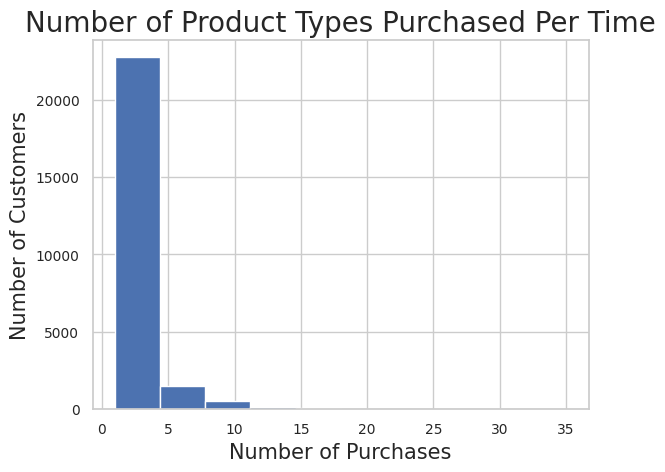

In [ ]:
# 한 개의 거래에서 구매하는 상품의 종류 수

all_cluster_invoiceno_count = all_cluster.groupby("거래ID").count()['제품ID']
plt.hist(all_cluster_invoiceno_count)

plt.title("Number of Product Types Purchased Per Time", fontsize=20)
plt.xlabel("Number of Purchases", fontsize=15)
plt.ylabel("Number of Customers", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

### 1-3-3) 실제 구매된 상품 중 최다 구매 상품 확인
- 실제 구매된 제품은 1,145개
- 최다 구매된 제품은 3,511개의 Product_0981

In [ ]:
all_cluster.제품ID.nunique()

1145

In [ ]:
no_stockcode_buy = all_cluster.groupby('제품ID').count()['거래ID']
no_stockcode_buy.sort_values(ascending=False)

제품ID
Product_0981    3511
Product_0983    3328
Product_0976    3230
Product_0984    1361
Product_0989    1089
                ... 
Product_0701       1
Product_0044       1
Product_0081       1
Product_0803       1
Product_0533       1
Name: 거래ID, Length: 1145, dtype: int64

### 1-3-3) 요일/ 월 별 구매율 차이
- 일요일과 월요일에 적은 구매수량 기록
- 6~7월 여름 시기에 재구매율과 구매수량이 동시에 높은 모습

In [ ]:
all_cluster['거래날짜'] = pd.to_datetime(all_cluster.거래날짜)
all_cluster_tmp = all_cluster
all_cluster_tmp['weekday'] = all_cluster.거래날짜.dt.weekday
all_cluster_tmp['month'] = all_cluster.거래날짜.dt.month
all_cluster_tmp = all_cluster
all_cluster_tmp['weekday'] = all_cluster.거래날짜.dt.weekday
all_cluster_tmp['month'] = all_cluster.거래날짜.dt.month

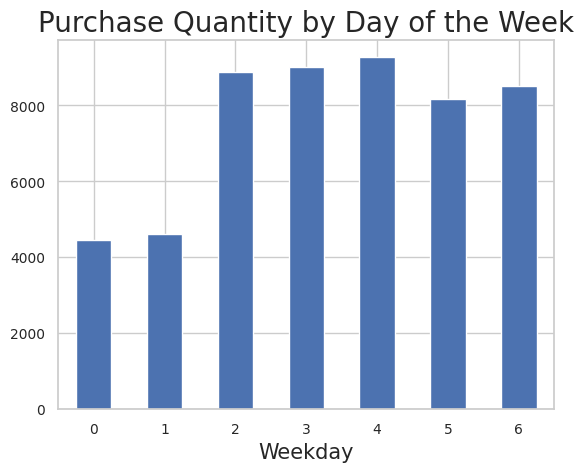

In [ ]:
all_cluster_tmp.groupby('weekday').count()['수량'].plot.bar()
plt.title("Purchase Quantity by Day of the Week", fontsize=20)
plt.xlabel("Weekday", fontsize=15)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

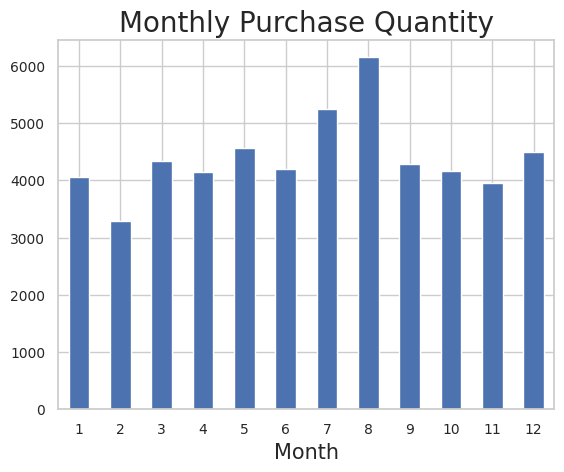

In [ ]:
all_cluster_tmp.groupby('month').count()['수량'].plot.bar()
plt.title("Monthly Purchase Quantity", fontsize=20)
plt.xlabel("Month", fontsize=15)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

### 1-3-4) 온라인 & 오프라인 마케팅 비용 분석

##### 1) 월별 온오프라인 마케팅 비용 추이

In [ ]:
marketing = pd.read_csv("/content/drive/MyDrive/kdt-data-33/DS_DE_33/pjt-1/dacon-raw-data/Marketing_info.csv")

marketing['날짜'] = pd.to_datetime(marketing.날짜)
marketing['월'] = marketing.날짜.dt.month
marketing.head()

,날짜,오프라인비용,온라인비용,월
0,2019-01-01,4500,2424.50,1
1,2019-01-02,4500,3480.36,1
2,2019-01-03,4500,1576.38,1
3,2019-01-04,4500,2928.55,1
4,2019-01-05,4500,4055.30,1


In [ ]:
marketing_month = marketing.groupby('월').sum()
marketing_month

,오프라인비용,온라인비용
월,,
1,96600,58328.95
2,81300,55807.92
3,73500,48750.09
4,96000,61026.83
5,65500,52759.64
6,80500,53818.14
7,67500,52717.85
8,85500,57404.15
9,83000,52514.54


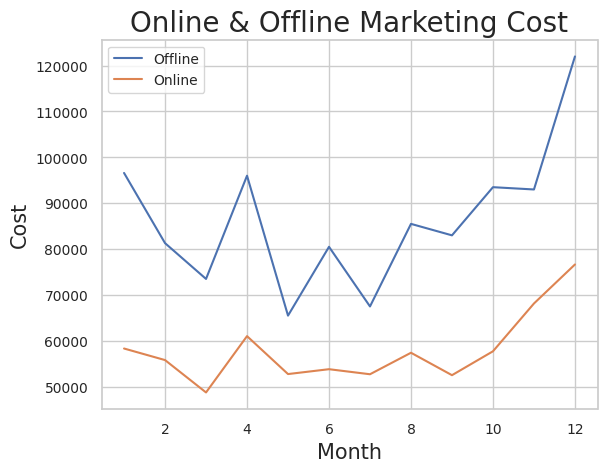

In [ ]:
plt.plot(marketing_month)
plt.title("Online & Offline Marketing Cost", fontsize=20)
plt.xlabel("Month", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(["Offline", "Online"], fontsize=10)
plt.show()

- 모든 달에서 온라인 마케팅 비용이 오프라인 마케팅 비용에 비해 적게 소요
- 온라인 마케팅 비용은 3월에, 오프라인 마케팅 비용은 5월에 가장 적게 소요
- 12월달에서 가장 많은 마케팅 비용 소요

##### 2) 월별 마케팅 이익 비교

가정:
- 오프라인 판매에 관한 데이터가 주어지지 않아서 판매량과 제품의 평균금액은 온라인과 동일하다고 가정

- 쿠폰할인은 온라인만 해당한다고 가정

- 배송료는 제품판매기업의 이익과 관계없다고 가정하여 고려하지 않음

- 온라인 수수료는 따로 부과되지 않는다고 가정

- 제품당 마진율은 30%로 일괄 책정되었다고 가정

- 온라인 매출 총 이익 : (마진율 *  쿠폰할인 적용 매출액) - 온라인 마케팅 비용
  * 쿠폰 사용 시에만 할인적용
-  오프라인 매출 총 이익 : (마진율 * 쿠폰할인 안된 매출액) - 오프라인 마케팅 비용

In [ ]:
# 필요없는 컬럼 삭제 및 가격 관련 수치 월별로 정리
price = all_cluster.drop(columns=['수량','GST', '평균금액', '배송료', '할인율', 'cluster_number', '쿠폰사용라벨링', "weekday", "month"])
price_month = price.groupby('월').sum()

In [ ]:
# 가격 및 마케팅 비용 데이터 프레임 생성
price_cost_month = pd.merge(price_month, marketing_month, on=["월"] )

In [ ]:
# 온라인 매출 이익 (쿠폰할인과 마진율 고려한 매출이익에서 온라인 마케팅에 소요된 비용의 차로 계산)
price_cost_month['온라인매출이익'] = price_cost_month['monetary']* 0.3 - price_cost_month['온라인비용']

# 오프라인 매출 이익(마진율 고려한 매출이익(쿠폰할인 없음)에서 오프라인 마케팅에 소요된 비용의 차로 계산)
price_cost_month['오프라인매출이익'] = price_cost_month['쿠폰 미적용 비용'] * 0.3 - price_cost_month['오프라인비용']

In [ ]:
profit = price_cost_month.drop(columns=['monetary', '구매가격', '부가세', '소비자부담가격', '쿠폰 미적용 비용', '오프라인비용', '온라인비용'])
profit

,온라인매출이익,오프라인매출이익
월,,
1,58866.8780,24487.374
2,31611.0198,11945.940
3,45942.3678,31382.427
4,55426.5751,24485.526
5,33902.5942,26829.026
6,32855.5245,15824.414
7,55469.8858,44291.421
8,54525.9112,34863.111
9,43653.5650,25164.520


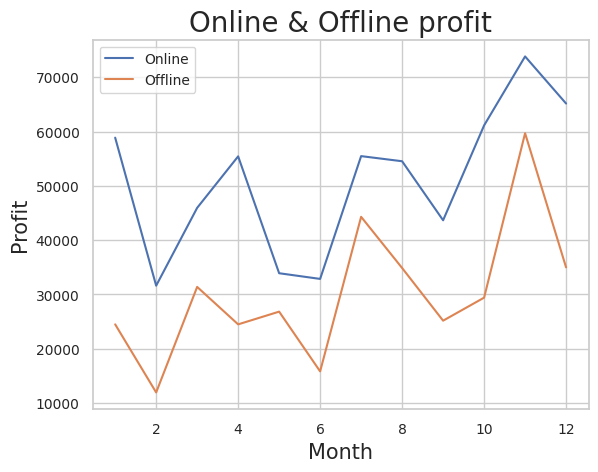

In [ ]:
# 월별 온라인 매출이익과 오프라인 매출이익 추이 그래프
plt.plot(profit)
plt.title("Online & Offline profit", fontsize=20)
plt.xlabel("Month", fontsize=15)
plt.ylabel("Profit", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(["Online","Offline"], fontsize=10)
plt.show()

- 모든 달에서 온라인 매출이익이 오프라인 매출이익보다 높음
- 11월에 온라인 오프라인 둘다 가장 높은 매출이익을 보임
- 2월에 온라인 오프라인 둘다 가장 낮은 매출이익을 나타냄
- 온오프라인 판매량을 동일하게 지정할 경우 온오프라인 매출이익은 유사한 추세를 보임
- 추후 정확한 오프라인 판매량을 적용한 분석 필요

In [ ]:
# 온라인 매출이익과 오프라인 매출이익의 월별 비율
profit["Ratio"] = profit["온라인매출이익"]/profit["오프라인매출이익"]
profit_ratio = profit.drop(columns=["온라인매출이익","오프라인매출이익"])
profit_ratio

,Ratio
월,
1,2.403969
2,2.646173
3,1.463952
4,2.263646
5,1.263654
6,2.076255
7,1.252384
8,1.564000
9,1.734727


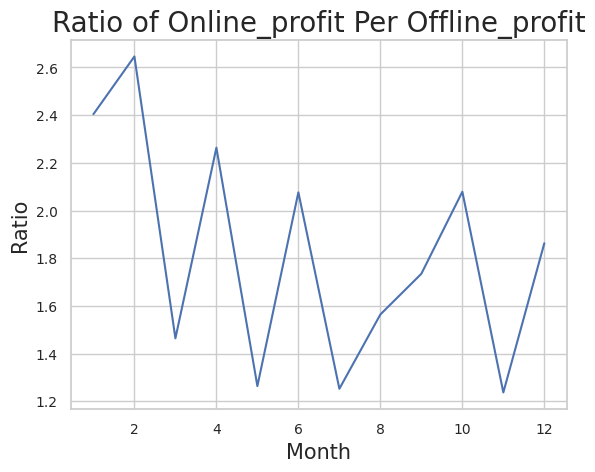

In [ ]:
plt.plot(profit_ratio)
plt.title("Ratio of Online_profit Per Offline_profit", fontsize=20)
plt.xlabel("Month", fontsize=15)
plt.ylabel("Ratio", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

- 2월에 온라인 매출이익과 오프라인 매출이익의 차이가 가장 큼 (약 2.65%)
- 11월에 온라인 매출이익과 오프라인 매출이익의 차이가 가장 작음 (약 1.24%)

In [ ]:
profit_diff = profit["온라인매출이익"].sum() / profit["오프라인매출이익"].sum()
round(profit_diff, 2)

1.69

- 2019년도 온라인 매출이익이 오프라인 매출이익에 비해 1.69% 높음
- 더 효율적인 온라인 마케팅을 통한 고객 유입 증진이 필요하다고 보임


### 1-3-5) 성별에 따른 구매 차이 분석

In [ ]:
# 남자 1인당 사용한 평균금액
man = all_cluster[all_cluster["성별"] == "남"]
monetary_per_man = man["monetary"].sum() / man["고객ID"].nunique()
round(monetary_per_man, 2)

3082.9

In [ ]:
# 여자 1인당 사용한 평균금액
woman = all_cluster[all_cluster["성별"] == "여"]
monetary_per_woman = woman["monetary"].sum() / woman["고객ID"].nunique()
round(monetary_per_woman, 2)

2905.52

In [ ]:
# 남자 1인당 평균금액과 여자 1인당 평균금액의 비율
monetary_ratio = monetary_per_man / monetary_per_woman
round(monetary_ratio,2)

1.06

In [ ]:
# 남자 1인당 평균 거래 횟수
man = all_cluster[all_cluster["성별"] == "남"]
transaction_per_man = man["거래ID"].count() / man["고객ID"].nunique()
round(transaction_per_man, 2)

37.3

In [ ]:
# 여자 1인당 평균 거래 횟수
woman = all_cluster[all_cluster["성별"] == "여"]
transaction_per_woman = woman["거래ID"].count() / woman["고객ID"].nunique()
round(transaction_per_woman, 2)

35.34

In [ ]:
# 남자 1인당 평균 거래 횟수와 여자 1인당 평균 거래 횟수의 비율
transaction_ratio = transaction_per_man / transaction_per_woman
round(transaction_ratio, 2)

1.06

In [ ]:
# 남자 1인당 제품 구매 수
man = all_cluster[all_cluster["성별"] == "남"]
product_per_man = man["수량"].sum() / man["고객ID"].nunique()
round(product_per_man, 2)

161.16

In [ ]:
# 여자 1인당 제품 구매 수
woman = all_cluster[all_cluster["성별"] == "여"]
product_per_woman = woman["수량"].sum() / woman["고객ID"].nunique()
round(product_per_woman, 2)

162.71

In [ ]:
# 남자 1인당 제품 구매 수와 여자 1인당 제품 구매 수의 비율
product_ratio = product_per_man/ product_per_woman
round(product_ratio, 2)

0.99

In [ ]:
# 성별에 따른 카테고리별 비율을 표로 정리
category_list = ["monetary", "transaction", "product"]
man_woman_ratio = [monetary_ratio,transaction_ratio, product_ratio]
gender_ratio = pd.DataFrame({"Category": category_list, "Ratio": man_woman_ratio})
round(gender_ratio, 2)

,Category,Ratio
0,monetary,1.06
1,transaction,1.06
2,product,0.99


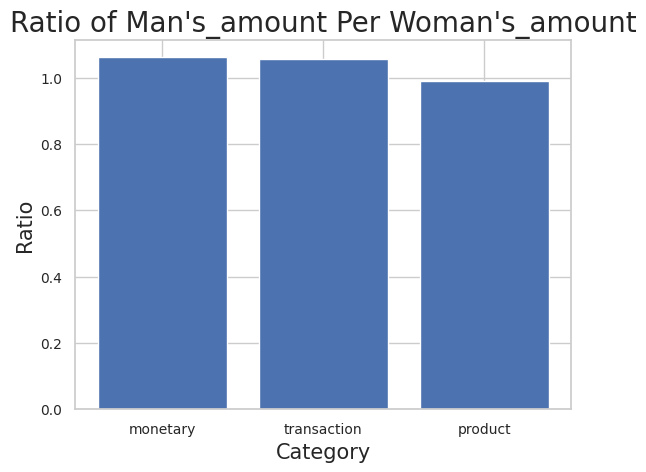

In [ ]:
# 성별에 따른 카테고리별 비율 차이를 그래프로 나타냄
plt.bar(gender_ratio.Category, gender_ratio.Ratio)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Category", fontsize=15)
plt.ylabel("Ratio", fontsize=15)
plt.title("Ratio of Man's_amount Per Woman's_amount", fontsize=20)
plt.show()

- **남자 한명당 소비 금액**, 거래횟수가 여자에 비해 큼 (**약 1.06배**)
- **여자 한명당 제품구매 수**는 남자에 비해 큼  
- 하지만 두드러진 차이는 보이지 않음 (거의 유사)

In [ ]:
# 성별에 따른 카테고리별 수치
man_summary = [monetary_per_man, transaction_per_man, product_per_man]
woman_summary = [monetary_per_woman, transaction_per_woman, product_per_woman]
gender_diff = pd.DataFrame({"Category": category_list,
                           "Man": man_summary,
                           "Woman": woman_summary
                            })
gender_diff

,Category,Man,Woman
0,monetary,3082.896107,2905.519958
1,transaction,37.297753,35.339400
2,product,161.164794,162.709850


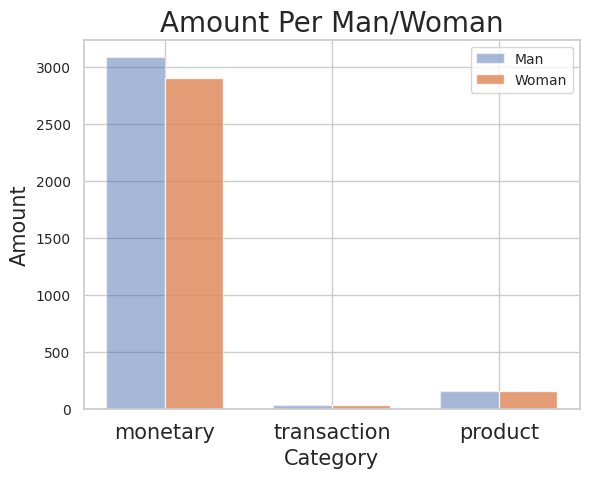

In [ ]:
# 성별에 따른 카테고리별 수치
xlabel = category_list
x = np.arange(len(xlabel))
y1 = man_summary
y2 = woman_summary

width = 0.35

fig, axes = plt.subplots()
axes.bar(x - width/2, y1, width, align='center', alpha=0.5)
axes.bar(x + width/2, y2, width, align='center', alpha=0.8)

plt.xticks(x, fontsize=10)
plt.yticks(fontsize=10)
axes.set_xticklabels(xlabel, fontsize=15)

plt.xlabel("Category", fontsize=15)
plt.ylabel("Amount", fontsize=15)
plt.legend(["Man","Woman"], fontsize=10)
plt.title("Amount Per Man/Woman", fontsize=20)
plt.show()

- 남녀에서 큰 차이 보이지 않음
- **성별에 따라 다른 마케팅을 할 필요는 없어보임**

### 1-3-6) 지역별 재구매율

- 총 지역 수는 5개 (chicago, california, new jersey, newyork, washingtonDC)
- **캘리포니아와 시카고**가 **유독 재구매율이 현저히 떨어지는 것**을 확인할 수 있음


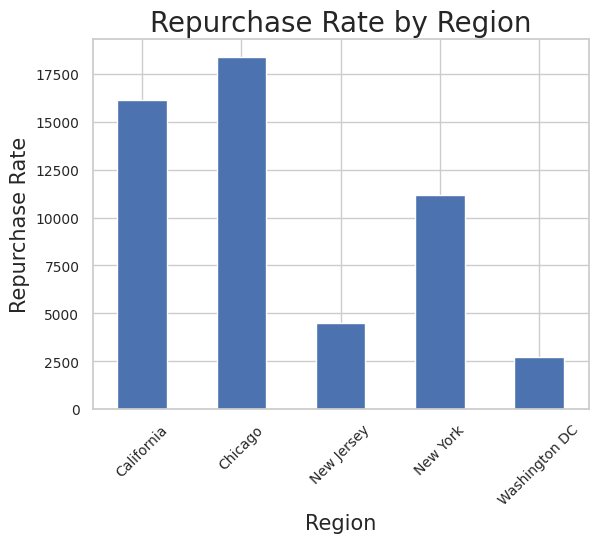

In [ ]:
all_cluster.groupby('고객지역').count()['수량'].plot.bar()
plt.title("Repurchase Rate by Region", fontsize=20)
plt.xlabel("Region", fontsize=15)
plt.ylabel("Repurchase Rate", fontsize=15)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()

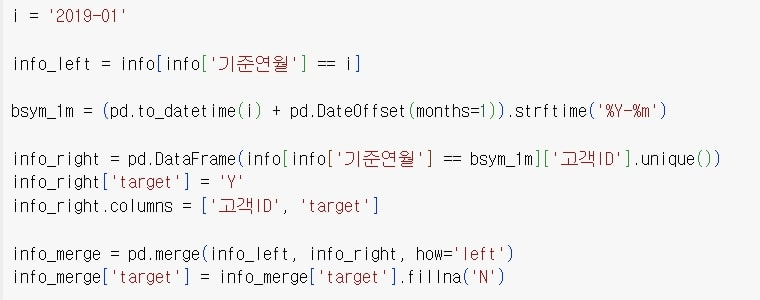

In [ ]:
import os
import glob
import cv2
from google.colab.patches import cv2_imshow

images_code = "/content/drive/MyDrive/kdt-data-33/DS_DE_33/pjt-1/dacon-raw-data/재구매율코드JPG.jpg"
image_code = cv2.imread(images_code)
cv2_imshow(image_code)

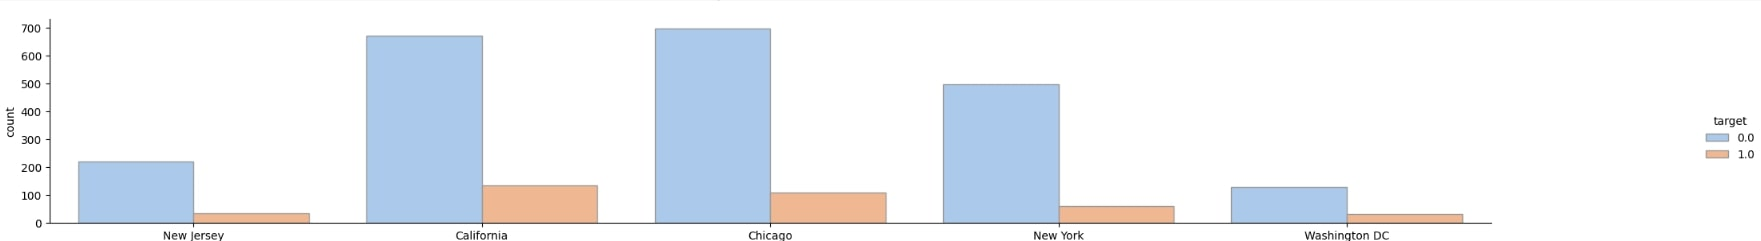

In [ ]:
images_result = "/content/drive/MyDrive/kdt-data-33/DS_DE_33/pjt-1/dacon-raw-data/구매비중JPG.jpg"
image_result = cv2.imread(images_result)
cv2_imshow(image_result)

- 지역별 재구매율의 차이가 있는 것을 확인할 수 있음.
- **지역별 고객들의 특성을 파악**하고, **지역별 고객 맞춤 솔루션을 제안**하기 위해 **지역별 RFM** 을 실시하기로 함.



# 2) RFM 분석

In [ ]:
all_cluster['거래날짜'] = pd.to_datetime(all_cluster.거래날짜)
# Recency

all_customer_last_date = all_cluster.groupby('고객ID').agg(max)['거래날짜'].reset_index()
all_customer_last_date["recency"] = (all_customer_last_date["거래날짜"] - all_cluster["거래날짜"].max()).dt.days
all_recency = all_customer_last_date.drop(columns=['거래날짜'])

# Frequency

all_frequency = all_cluster[['고객ID', '거래ID']].drop_duplicates().groupby('고객ID').count().reset_index()
all_frequency.rename(columns = {'거래ID' : 'frequency'}, inplace=True)
# Monetary

all_cluster['monetary_row'] = all_cluster['수량'] * all_cluster['평균금액']
all_monetary = all_cluster.groupby('고객ID').agg(sum)["monetary_row"].reset_index()
all_monetary.rename(columns = {'monetary_row' : 'monetary'}, inplace=True )

In [ ]:
all_rfm = all_recency.merge(all_frequency, on="고객ID").merge(all_monetary, on='고객ID')

K-Means Clustering 사용

In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

scaler = MinMaxScaler()
list_scaling = ["recency", "frequency", "monetary"]
all_rfm.loc[:, list_scaling] = scaler.fit_transform(all_rfm[list_scaling])

# 스케일링 진행한 RFM
all_rfm.head(2)

,고객ID,recency,frequency,monetary
0,USER_0000,0.706044,0.000000,0.000395
1,USER_0001,0.837912,0.091743,0.182177


클러스터 갯수 정하기

In [ ]:
X_features_scaled = all_rfm[["recency", "frequency", "monetary"]].values

In [ ]:
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    n_cols = len(cluster_lists)

    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):

        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [ ]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np

    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

    for ind, n_cluster in enumerate(cluster_lists):

        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

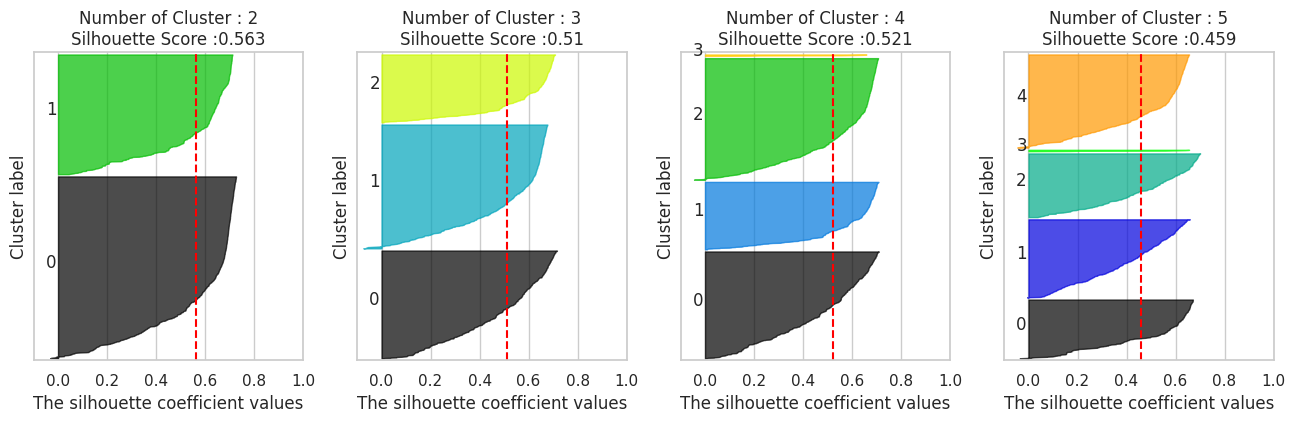

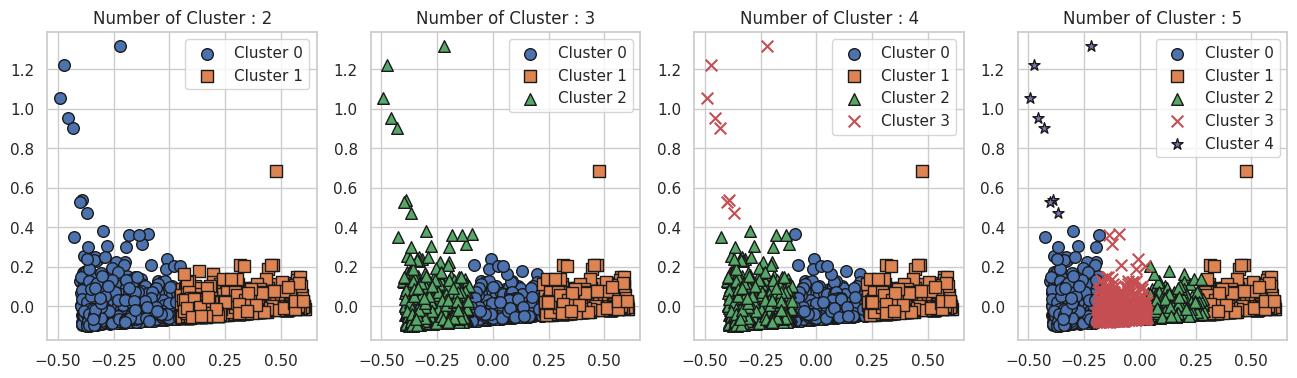

In [ ]:
import numpy as np

visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

정리

- 군집의 모양을 확인하던중, **3개와 4개** 클러스터 시각화에서,
동일한 이상치가(그래프상 왼쪽 상단) 확인되어<BR> **이상치**를 **따로** 두고 **분류**가 되는 **cluster 개수를 4개로 결정**<br>
  - 클러스터 갯수를 3개로 했을 경우, 이상치 까지 초록색 세모로 포함해 군집을 만들었지만, <BR>
  - 클러스터 갯수를 **4개**로 했을 경우, **이상치를 빨간색 X 로 구분해 군집**을 만들었음

#### K-Means RFM

In [ ]:
# 머신러닝 학습
km_final = KMeans(n_clusters=4, random_state = 42)
km_final = km_final.fit(all_rfm.drop("고객ID", axis=1))

# 학습시킨 결과, "cluster_number" 컬럼으로 추가
all_rfm['cluster_number'] = km_final.predict(all_rfm.drop('고객ID', axis =1))

In [ ]:
# cluster별 RFM score 패턴을 확인
cluster_result = all_rfm.drop(columns=["고객ID"]).groupby("cluster_number").agg(np.mean)
cluster_result

,recency,frequency,monetary
cluster_number,,,
0,0.556230,0.038058,0.027230
1,0.191233,0.034324,0.028150
2,0.871462,0.066140,0.054375
3,0.928571,0.727064,0.645770


- 각 클러스별 고객 등급은 나중에 작성

- **0번** 클러스터 : **526명**
- **1번** 클러스터 : **335명**
- **2번** 클러스터 : **599명**
- **3번** 클러스터 : **8명** => 이상치만 포함된 클러스터지만, RFM 수치 확인 시 높은 Monetary를 가진 **VIP**로 판단되어 별도로 확인 진행하기로 함.

# 3) 클러스터 별 진행

## 3-0) 필요한 데이터프레임 만들기

### 1) 0번 클러스터

- 클러스터 0번 DF 뽑기

In [ ]:
cluster_0 = all_cluster.loc[all_cluster['cluster_number'] == 0]

In [ ]:
cluster_0 = cluster_0.reset_index()
cluster_0 = cluster_0.drop("index", axis=1)

In [ ]:
cluster_0.head(3)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,기준연월,...,cluster_number,구매가격,부가세,소비자부담가격,쿠폰사용라벨링,monetary,쿠폰 미적용 비용,weekday,month,monetary_row
0,USER_0066,Transaction_0009,2019-01-01,Product_0185,Office,1,2.47,102.79,Used,2019-01,...,0,2.47,0.2470,105.5070,1,2.223,2.47,1,1,2.47
1,USER_0066,Transaction_0009,2019-01-01,Product_0879,Drinkware,26,8.72,102.79,Clicked,2019-01,...,0,226.72,40.8096,370.3196,0,226.720,226.72,1,1,226.72
2,USER_0066,Transaction_0009,2019-01-01,Product_0904,Office,1,1.64,102.79,Clicked,2019-01,...,0,1.64,0.1640,104.5940,0,1.640,1.64,1,1,1.64


In [ ]:
cluster_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14977 entries, 0 to 14976
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   고객ID            14977 non-null  object        
 1   거래ID            14977 non-null  object        
 2   거래날짜            14977 non-null  datetime64[ns]
 3   제품ID            14977 non-null  object        
 4   제품카테고리          14977 non-null  object        
 5   수량              14977 non-null  int64         
 6   평균금액            14977 non-null  float64       
 7   배송료             14977 non-null  float64       
 8   쿠폰상태            14977 non-null  object        
 9   기준연월            14977 non-null  object        
 10  월               14977 non-null  int64         
 11  성별              14977 non-null  object        
 12  고객지역            14977 non-null  object        
 13  GST             14977 non-null  float64       
 14  쿠폰코드            14842 non-null  object        
 15  할인

In [ ]:
cluster_0['부가세'] = cluster_0['monetary'] * cluster_0['GST']
cluster_0.head(3)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,기준연월,...,cluster_number,구매가격,부가세,소비자부담가격,쿠폰사용라벨링,monetary,쿠폰 미적용 비용,weekday,month,monetary_row
0,USER_0066,Transaction_0009,2019-01-01,Product_0185,Office,1,2.47,102.79,Used,2019-01,...,0,2.47,0.2223,105.5070,1,2.223,2.47,1,1,2.47
1,USER_0066,Transaction_0009,2019-01-01,Product_0879,Drinkware,26,8.72,102.79,Clicked,2019-01,...,0,226.72,40.8096,370.3196,0,226.720,226.72,1,1,226.72
2,USER_0066,Transaction_0009,2019-01-01,Product_0904,Office,1,1.64,102.79,Clicked,2019-01,...,0,1.64,0.1640,104.5940,0,1.640,1.64,1,1,1.64


### 2) 고객별 구매가격, 부가세, 배송료, 소비자부담가격 데이터프레임

In [ ]:
# 클러스터0에서 고유한 고객ID & 거래ID 피벗 테이블 생성
cluster_0_total_price = pd.pivot_table(
    cluster_0,
    index = ["고객ID",  "거래ID"]
)
cluster_0_total_price = cluster_0_total_price.drop(["GST", "cluster_number", "monetary","구매가격", "부가세","소비자부담가격", "수량",  "쿠폰사용라벨링", "평균금액", "할인율"], axis=1)
cluster_0_total_price = cluster_0_total_price.reset_index()
cluster_0_total_price.head(3)

,고객ID,거래ID,monetary_row,month,weekday,배송료,월,쿠폰 미적용 비용
0,USER_0000,Transaction_16900,15.495,9,6,75.0,9,15.495
1,USER_0004,Transaction_16887,11.890,9,6,6.0,9,11.890
2,USER_0004,Transaction_16888,10.390,9,6,6.5,9,10.390


In [ ]:
# 클러스터2에서 고유한 고객ID & 거래ID monetary, 부가세 총합 그루핑
gb1 = cluster_0.groupby(["고객ID", "거래ID"])[["monetary", "부가세"]].sum()
gb1 = gb1.reset_index()
gb1.head(3)

,고객ID,거래ID,monetary,부가세
0,USER_0000,Transaction_16900,21.693,3.28874
1,USER_0004,Transaction_16887,8.323,1.49814
2,USER_0004,Transaction_16888,10.390,1.87020


In [ ]:
cluster_0_total_price = pd.merge(cluster_0_total_price, gb1, on=["고객ID", "거래ID"])
cluster_0_total_price.head(3)

,고객ID,거래ID,monetary_row,month,weekday,배송료,월,쿠폰 미적용 비용,monetary,부가세
0,USER_0000,Transaction_16900,15.495,9,6,75.0,9,15.495,21.693,3.28874
1,USER_0004,Transaction_16887,11.890,9,6,6.0,9,11.890,8.323,1.49814
2,USER_0004,Transaction_16888,10.390,9,6,6.5,9,10.390,10.390,1.87020


In [ ]:
# 소비자부담가격 컬럼 추가
cluster_0_total_price["소비자부담가격"] = cluster_0_total_price["배송료"] + cluster_0_total_price["부가세"]
# 소비자총부담가격 컬럼 추가
cluster_0_total_price["소비자총부담가격"] = cluster_0_total_price["monetary"] + cluster_0_total_price["배송료"] + cluster_0_total_price["부가세"]

In [ ]:
# 고유 고객ID별 고객지역 데이터프레임 분리
gb_reg = cluster_0[["고객ID","고객지역"]]
gb_reg = gb_reg.drop_duplicates(["고객ID"])

# 고객지역 컬럼 병합
cluster_0_total_price = pd.merge(cluster_0_total_price, gb_reg, on=["고객ID"])
cluster_0_total_price = cluster_0_total_price[["고객ID", "거래ID", "고객지역", "monetary", "월", "배송료", "부가세", "소비자부담가격", "소비자총부담가격"]]

In [ ]:
cluster_0_total_price.head(3)

,고객ID,거래ID,고객지역,monetary,월,배송료,부가세,소비자부담가격,소비자총부담가격
0,USER_0000,Transaction_16900,New York,21.693,9,75.0,3.28874,78.28874,99.98174
1,USER_0004,Transaction_16887,Chicago,8.323,9,6.0,1.49814,7.49814,15.82114
2,USER_0004,Transaction_16888,Chicago,10.390,9,6.5,1.87020,8.37020,18.76020


In [ ]:
cluster_0_total_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7072 entries, 0 to 7071
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   고객ID      7072 non-null   object 
 1   거래ID      7072 non-null   object 
 2   고객지역      7072 non-null   object 
 3   monetary  7072 non-null   float64
 4   월         7072 non-null   int64  
 5   배송료       7072 non-null   float64
 6   부가세       7072 non-null   float64
 7   소비자부담가격   7072 non-null   float64
 8   소비자총부담가격  7072 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 552.5+ KB


In [ ]:
cluster_0["고객ID"].nunique(), cluster_0_total_price["고객ID"].nunique()

(526, 526)

### 3) 재구매자 라벨링 데이터프레임

In [ ]:
reorder_pt = cluster_0.pivot_table(index = "고객ID", columns = "거래날짜", values="거래ID", aggfunc="count")
reorder_pt = reorder_pt.fillna(0)

In [ ]:
U = len(reorder_pt.index)
reorder_cnt = []
for i in range(U):
  row = reorder_pt.iloc[i]
  r = row.values
  cnt = 0
  for num in r:
    if cnt >= 2:
      break
    elif num >= 1:
      cnt += 1
    elif num == 0:
      continue
  if cnt == 2:
    cnt = 1
    reorder_cnt.append(cnt)
  elif cnt == 1:
    cnt = 0
    reorder_cnt.append(cnt)

# cluster 0번 고객수 출력
len(reorder_cnt)

526

In [ ]:
# 재구매자 라벨링 컬럼 추가
reorder_pt["재구매자 라벨링"] = reorder_cnt
reorder_pt = reorder_pt.reset_index()
reorder_df = reorder_pt.copy()
reorder_df = reorder_df[["고객ID", "재구매자 라벨링"]]

In [ ]:
reorder_all_df = pd.DataFrame({"고객ID" : cluster_0["고객ID"].unique()})
reorder_all_df = pd.merge(reorder_all_df, reorder_df, on="고객ID")
reorder_all_df.head(3)

,고객ID,재구매자 라벨링
0,USER_0066,1
1,USER_0683,1
2,USER_0351,1


### 4) 지역별 데이터프레임

In [ ]:
Chicago_0_cluster = cluster_0.loc[cluster_0["고객지역"] == "Chicago"]
California_0_cluster = cluster_0.loc[cluster_0["고객지역"] == "California"]
NewJersey_0_cluster = cluster_0.loc[cluster_0["고객지역"] == "New Jersey"]
NewYork_0_cluster = cluster_0.loc[cluster_0["고객지역"] == "New York"]
WashingtonDC_0_cluster = cluster_0.loc[cluster_0["고객지역"] == "Washington DC"]

### 5) 지역별 구매 횟수

In [ ]:
cluster_0_region_order_cnt = cluster_0.pivot_table(index="고객지역", values="거래ID", aggfunc=len)
cluster_0_region_order_cnt.sort_values(by='거래ID', ascending=False)

,거래ID
고객지역,
Chicago,4970
California,4168
New York,3935
New Jersey,1401
Washington DC,503


### 6) 지역별 고객 수

In [ ]:
cluster_0_region_user = pd.DataFrame({
    "고객지역" : ["California", "Chicago", "New York", "New Jersey", "Washington DC"],
    "고객ID" : [ cluster_0[cluster_0["고객지역"] == "California"]["고객ID"].nunique(),
              cluster_0[cluster_0["고객지역"] == "Chicago"]["고객ID"].nunique(),
               cluster_0[cluster_0["고객지역"] == "New York"]["고객ID"].nunique(),
               cluster_0[cluster_0["고객지역"] == "New Jersey"]["고객ID"].nunique(),
               cluster_0[cluster_0["고객지역"] == "Washington DC"]["고객ID"].nunique()]
    })
cluster_0_region_user

,고객지역,고객ID
0,California,162
1,Chicago,163
2,New York,127
3,New Jersey,54
4,Washington DC,20


### 7) 카테고리별 주문 횟수

In [ ]:
# 휴면고객들의 카테고리별 주문 횟수
cluster_0_category_order_cnt = cluster_0.pivot_table(index="제품카테고리", values="거래ID", aggfunc=len)
cluster_0_category_order_cnt.sort_values(by="거래ID", ascending=False)

,거래ID
제품카테고리,
Apparel,5956
Nest-USA,3465
Office,1787
Drinkware,1003
Lifestyle,986
Bags,529
Notebooks & Journals,297
Headgear,265
Waze,146


# 1) 시카고

## 1-1 ) 월별 구매 분석

### (1) 월별 전체 구매율 비교
- 전체 구매금액에서 월별 구매금액이 차지하는 비중
- 월별 구매금액 / 전체금액 * 100

In [ ]:
# 클러스터0번이 시카고 고객 총 구매 금액
chic_0_purchase_amt = cluster_0_total_price[cluster_0_total_price["고객지역"]=="Chicago"].groupby("고객지역")["소비자총부담가격"].agg([
    ("전체 구매금액" , sum)
])

# for문 이용하여 데이터프레임에 월별 시카고 고객의 구매 금액 삽입
l = []
for i in range(1, cluster_0_total_price["월"].nunique() + 1 ):
  month = cluster_0_total_price[cluster_0_total_price["월"] == i ]

  r1 = month[month["고객지역"] == "Chicago"]
  r1_s = r1["소비자총부담가격"].sum()
  l.append(r1_s)

  chic_0_purchase_amt[f"{i}"] = l
  l = []

In [ ]:
chic_0_purchase_amt

,전체 구매금액,1,2,3,4,5,6,7,8,9
고객지역,,,,,,,,,,
Chicago,388330.01324,14216.20564,20052.891,24779.15748,35432.22286,43726.14244,56063.31842,70697.0604,74858.75198,48504.26302


In [ ]:
# 구매비율 데이터프레임
chic_0_purchase_ratio = pd.DataFrame(index = ["Chicago"])

# 비율 컬럼 삽
for i in range(1, cluster_0_total_price["월"].nunique()+1):
  p = chic_0_purchase_amt[f"{i}"]
  chic_0_purchase_ratio[f"{i}"] = p / chic_0_purchase_amt["전체 구매금액"] * 100

In [ ]:
chic_0_purchase_ratio

,1,2,3,4,5,6,7,8,9
Chicago,3.660857,5.163879,6.380953,9.124256,11.260047,14.437029,18.205407,19.277097,12.490475


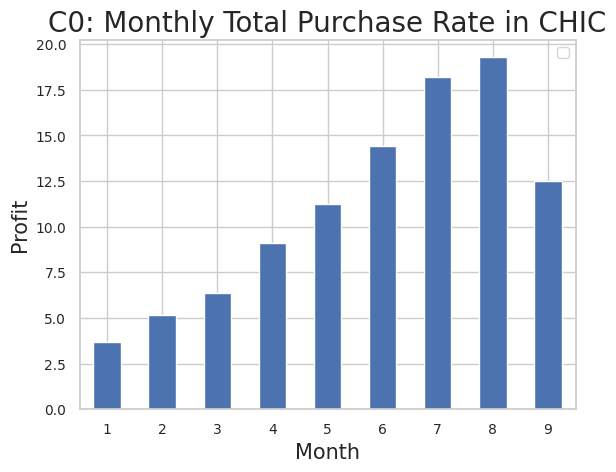

In [ ]:
chic_0_purchase_ratio.T.plot.bar()

plt.title("C0: Monthly Total Purchase Rate in CHIC", fontsize=20)
plt.xlabel("Month", fontsize=15)
plt.ylabel("Profit", fontsize=15)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.legend("", fontsize=10)

plt.show()

### (2) 주문횟수로 본 월별 구매율
- 월별 주문횟수(거래ID) / 전체 구매횟수 * 100

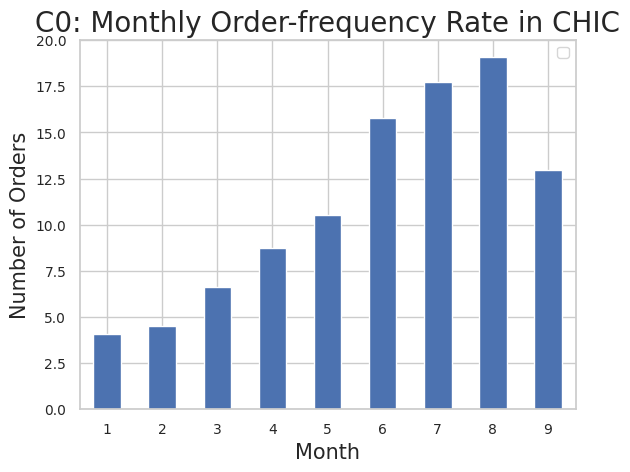

In [ ]:
def Chicago_0_cluster_order(x):
  mask = Chicago_0_cluster['월'] == x
  data = Chicago_0_cluster[mask]['거래ID'].nunique() / Chicago_0_cluster['거래ID'].nunique() * 100
  return round(data, 2)

Chicago_0_cluster_order_all = [Chicago_0_cluster_order(month) for month in range(1, 10)]
Chicago_0_cluster_order_all_df = pd.DataFrame(Chicago_0_cluster_order_all, index=(i for i in range(1,10)))
Chicago_0_cluster_order_all_df

Chicago_0_cluster_order_all_df.transpose().T.plot.bar()

plt.title("C0: Monthly Order-frequency Rate in CHIC", fontsize=20)
plt.xlabel("Month", fontsize=15)
plt.ylabel("Number of Orders", fontsize=15)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.legend("", fontsize=10)

plt.show()

### (3) 한달 내 재구매율
- 재구매율 용어 정리 <br>
Y = "다음 달에도 재구매한 사용자 수" <br>
ratio = "다음 달에도 재구매한 비율" <br>
total = "해당 월 주문횟수"

In [ ]:
chicago_re = Chicago_0_cluster[["기준연월", "고객ID"]].drop_duplicates(keep="first")

In [ ]:
loop_list = list(chicago_re['기준연월'].unique())   # loop_list =  ['2019-01', '2019-02', '2019-03' ... '2019-09']
chic_cluster_0_re_all = []

for i in loop_list:
  c0_left = chicago_re[chicago_re['기준연월'] == i]
  bsym_1m = (pd.to_datetime(i) + pd.DateOffset(months=1)).strftime('%Y-%m')    # 2019-01 + 1달 -> 2019-02 를 string 타입으로 변경
  c0_right = pd.DataFrame(chicago_re[chicago_re['기준연월'] == bsym_1m]['고객ID'].unique())   # 데이터프레임
  c0_right['target'] = 1
  c0_right.columns= ['고객ID', 'target']
  c0_merge = pd.merge(c0_left, c0_right, how='left')
  c0_merge['target'] = c0_merge['target'].fillna(0)

  chic_cluster_0_re_all.append(c0_merge)

chic_cluster_0_re_all = pd.concat(chic_cluster_0_re_all)

chicago_re.shape, chic_cluster_0_re_all.shape,

((257, 2), (257, 3))

In [ ]:
chic_repurchase = chic_cluster_0_re_all.groupby('기준연월')['target'].agg(['sum', 'count']).reset_index()
chic_repurchase.columns = ['기준연월', 'Y', 'Total']
chic_repurchase['ratio'] = chic_repurchase['Y']/chic_repurchase['Total']
chic_repurchase = chic_repurchase.iloc[0:11, :]

In [ ]:
chic_repurchase

,기준연월,Y,Total,ratio
0,2019-01,1.0,11,0.090909
1,2019-02,0.0,8,0.000000
2,2019-03,2.0,18,0.111111
3,2019-04,3.0,26,0.115385
4,2019-05,5.0,25,0.200000
5,2019-06,6.0,47,0.127660
6,2019-07,7.0,41,0.170732
7,2019-08,3.0,54,0.055556
8,2019-09,0.0,27,0.000000


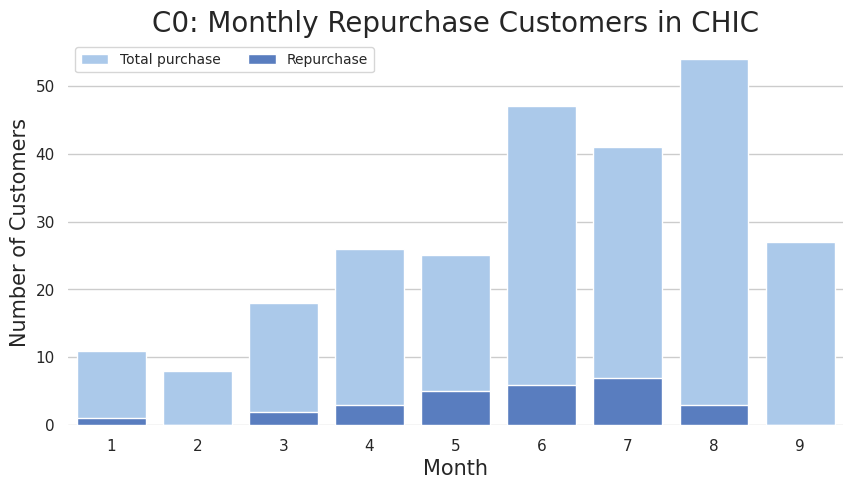

In [ ]:
chic_repurchase['기준연월'] = [i for i in range(1, 10)]

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(figsize=(10, 5))
sns.set_color_codes('pastel')

sns.barplot(x='기준연월',
            y='Total',
            data=chic_repurchase,
            label='Total purchase',
            color='b')

sns.set_color_codes('muted')
sns.barplot(x='기준연월',
            y='Y',
            data=chic_repurchase,
            label='Repurchase',
            color='b')

axes.set_title("C0: Monthly Repurchase Customers in CHIC", fontsize='20')
axes.set_xlabel('Month', fontsize='15')
axes.set_ylabel('Number of Customers', fontsize='15')

axes.legend(ncol=2, frameon=True, fontsize=10)
sns.despine(left=True, bottom=True)

### (4) 전체 기간의 재구매자 비율
- 재구매자 / 전체 고객수 * 100

In [ ]:
Chicago_0_cluster = cluster_0.loc[cluster_0["고객지역"] == "Chicago"]

# 고객ID 별 거래날짜 테이블 추가 생성하여 주문횟수 확인
chi_order_cnt_df = pd.pivot_table(Chicago_0_cluster,
               index= "고객ID",
               columns = "거래날짜",
               values = "거래ID",
               aggfunc = "count"
               )
chi_order_cnt_df = chi_order_cnt_df.fillna(0)

In [ ]:
N = len(chi_order_cnt_df.index)   # 인덱스 개수 (0번 클러스터의 고객)
re = []
for i in range(N):
  row = chi_order_cnt_df.iloc[i]  # 0번행 추출
  r = row.values  # 0번 행의 값들만 리스트로 추출 r = [0,0,0,0,1,0, 10, ...]
  cnt = 0
  for num in r:
    if cnt >= 2 :
      break    # cnt가 2번 이상 => 재구매 고객으로 break
    elif num >= 1 :
      cnt += 1  # 구매횟수(num) >= 1 => 해당 날짜에 구매한 것으로 간주하여 +1
    elif num == 0:
      continue   # num == 0 => 해당 날짜에 구매하지 않은 것으로 간주하여 for문 계속 진행

  if cnt == 2: # cnt == 2 => 재구매 고객으로 +1
    cnt = 1
    re.append(cnt)
  elif cnt == 1:  # cnt == 1 => 0
    cnt = 0
    re.append(cnt)

# 0번 클러스터 시카고 고객의 재구매율 = 재구매자 / 전체 고객수 * 100
cago_0_re_ratio = sum(re) /N * 100
print("chicago 재구매자 비율 : ", round(cago_0_re_ratio, 2))

chicago 재구매자 비율 :  47.24


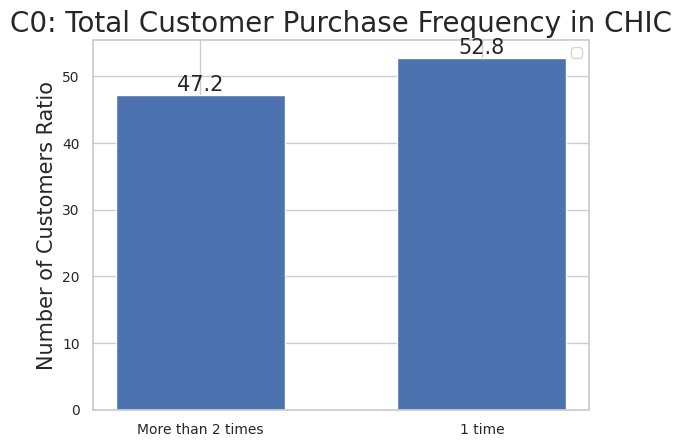

In [ ]:
x = ["More than 2 times", "1 time"]
y = [cago_0_re_ratio, 100- cago_0_re_ratio]
bar = plt.bar(x,y,width=0.6)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 15)

plt.title("C0: Total Customer Purchase Frequency in CHIC", fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Number of Customers Ratio', fontsize=15)
plt.legend("", fontsize=10)

plt.show()

## 1-2 ) 선호품목

In [ ]:
# 주문수량 기준, 상위 5개 카테고리 추출
chic_categ_quant_top5_index = Chicago_0_cluster.groupby("제품카테고리")["수량"].sum().sort_values(ascending = False).index[:5]
chic_categ_quant_top5_df = Chicago_0_cluster[Chicago_0_cluster["제품카테고리"].isin(chic_categ_quant_top5_index)]

chic_categ_quant_top5_pt = pd.pivot_table(
    chic_categ_quant_top5_df,
    index = "기준연월",
    columns = "제품카테고리",
    values = "수량",
    aggfunc = "sum"
)
chic_categ_quant_top5_pt

제품카테고리,Apparel,Drinkware,Lifestyle,Nest-USA,Office
기준연월,,,,,
2019-01,53,40,4,81,86
2019-02,107,195,145,88,299
2019-03,197,87,177,102,669
2019-04,404,142,68,149,512
2019-05,411,264,157,179,945
2019-06,342,466,434,279,1656
2019-07,500,696,480,327,1157
2019-08,654,1110,540,274,1480
2019-09,348,910,650,197,936


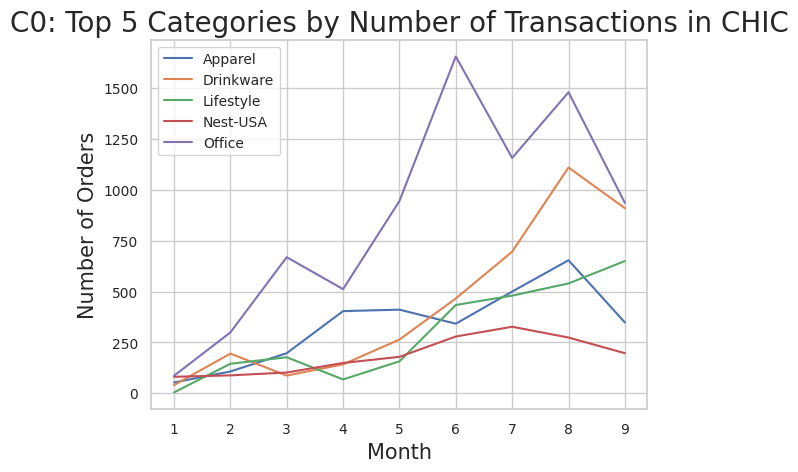

In [ ]:
for col in chic_categ_quant_top5_pt.columns:
  plt.plot([i for i in range(1,10)], chic_categ_quant_top5_pt[col], label = col)

plt.title("C0: Top 5 Categories by Number of Transactions in CHIC", fontsize=20)
plt.xlabel("Month", fontsize=15)
plt.ylabel("Number of Orders", fontsize=15)
plt.xticks([i for i in range(1,10)], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.show()

In [ ]:
# 주문횟수 기준, 상위 5개 카테고리 추출
chic_categ_ordercnt_top5_index = Chicago_0_cluster.groupby("제품카테고리")["거래ID"].count().sort_values(ascending=False).index[:5]
chic_categ_ordercnt_top5_df = Chicago_0_cluster[Chicago_0_cluster["제품카테고리"].isin(chic_categ_ordercnt_top5_index)]

chic_categ_ordercnt_top5_pt = pd.pivot_table(
    chic_categ_ordercnt_top5_df,
    index = "기준연월",
    columns = "제품카테고리",
    values = "거래ID",
    aggfunc = "count"
).fillna(0)

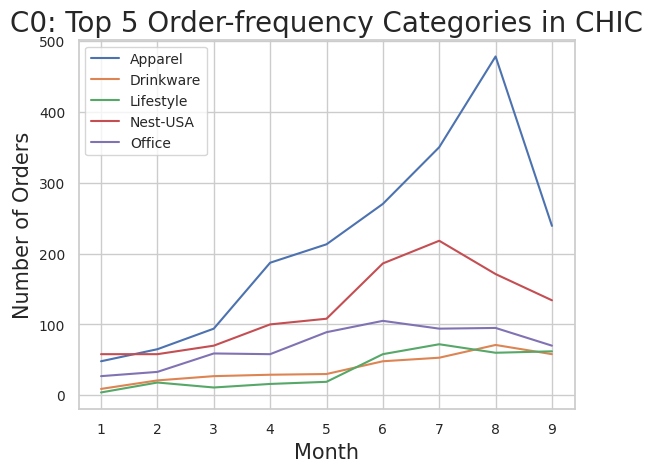

In [ ]:
for col in chic_categ_ordercnt_top5_pt.columns:
  plt.plot([i for i in range(1, 10)], chic_categ_ordercnt_top5_pt[col], label=col)

plt.title("C0: Top 5 Order-frequency Categories in CHIC", fontsize=20)
plt.xlabel("Month", fontsize=15)
plt.ylabel("Number of Orders", fontsize=15)
plt.xticks([i for i in range(1, 10)], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.show()

## 1-3) 카테고리별 쿠폰 사용

In [ ]:
chic_categ_ordercnt_top5_df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,기준연월,...,cluster_number,구매가격,부가세,소비자부담가격,쿠폰사용라벨링,monetary,쿠폰 미적용 비용,weekday,month,monetary_row
0,USER_0066,Transaction_0009,2019-01-01,Product_0185,Office,1,2.47,102.79,Used,2019-01,...,0,2.47,0.2223,105.5070,1,2.223,2.47,1,1,2.47
1,USER_0066,Transaction_0009,2019-01-01,Product_0879,Drinkware,26,8.72,102.79,Clicked,2019-01,...,0,226.72,40.8096,370.3196,0,226.720,226.72,1,1,226.72
2,USER_0066,Transaction_0009,2019-01-01,Product_0904,Office,1,1.64,102.79,Clicked,2019-01,...,0,1.64,0.1640,104.5940,0,1.640,1.64,1,1,1.64
3,USER_0066,Transaction_0009,2019-01-01,Product_1134,Office,1,1.64,102.79,Clicked,2019-01,...,0,1.64,0.1640,104.5940,0,1.640,1.64,1,1,1.64
5,USER_0066,Transaction_0010,2019-01-01,Product_0677,Apparel,1,61.89,6.50,Clicked,2019-01,...,0,61.89,11.1402,79.5302,0,61.890,61.89,1,1,61.89


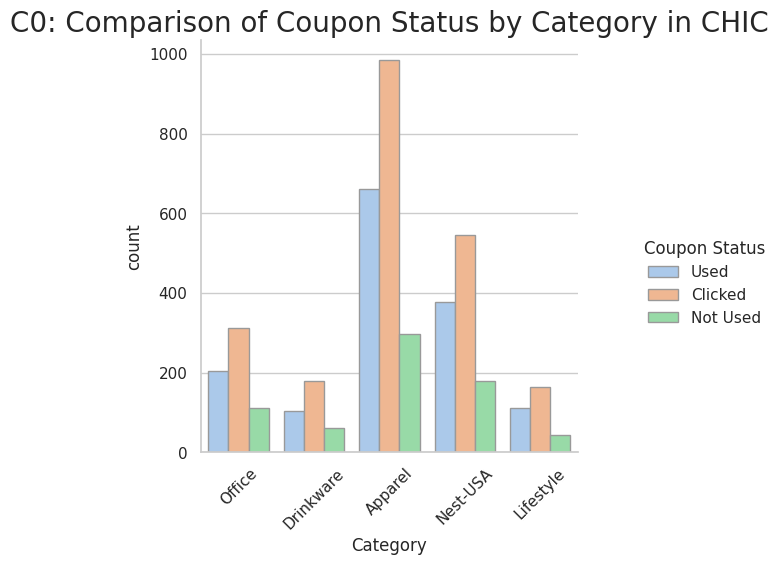

In [ ]:
g = sns.catplot(x='제품카테고리', hue='쿠폰상태', kind ='count', palette='pastel', edgecolor=".6",data=chic_categ_ordercnt_top5_df)

mpl.rcParams['axes.titlesize']  = 20
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
g._legend.set_title('Coupon Status')
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.title('C0: Comparison of Coupon Status by Category in CHIC')
plt.show()

- 나머지 클러스터(1,2,3)와 지역들(california, newjersey, newyork, washingtonDC)은 위 코드와 똑같이 진행하였다. <br>
각 클러스터별 5개 지역과 관련된 코드를 보고싶다면 해당 링크로... -> git hub 주소

# 4) 지역별 비교
- 해당 코드는 지역별 분석을 모두 진행 후 한번에 보는 시각화 자료
- 다른 지역에 할당된 변수들을 해당 파일에서 불러올수는 없으니, 사진으로 대체하므로 자세한 내용은 첨부된 구글 드라이브를 참고

## 4-1) 월별 구매분석

- 구매 비율 기준

In [ ]:
# cluster_0_purchase_ratio = pd.concat([chic_0_purchase_ratio, cali_0_purchase_ratio, nj_0_purchase_ratio, ny_0_purchase_ratio, wdc_0_purchase_ratio])

In [ ]:
# cluster_0_purchase_ratio

In [ ]:
# cluster_0_purchase_ratio.T.plot()
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.xlabel("Month", fontsize=15)
# plt.ylabel("Purchase Cost Rate", fontsize=15)
# plt.legend(fontsize=10)
# plt.title('C1: Comparison of Purcharse Cost Rates by Region', fontsize=20)
# plt.show()

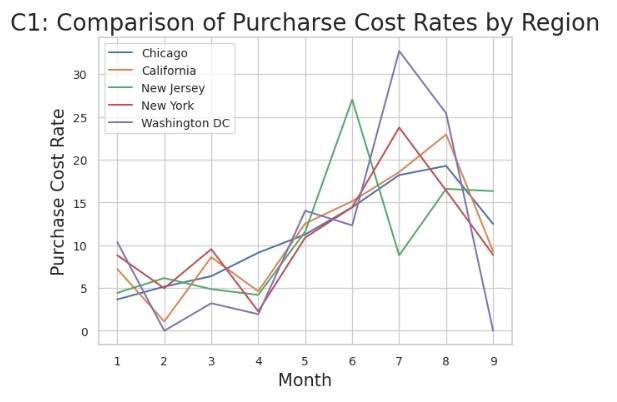

In [ ]:
images_code_Comparison_of_Purcharse_Costs_by_Region = "/content/drive/MyDrive/kdt-data-33/DS_DE_33/pjt-1/dacon-raw-data/월별구매비율.jpg"
image_code_Comparison_of_Purcharse_Costs_by_Region = cv2.imread(images_code_Comparison_of_Purcharse_Costs_by_Region)
cv2_imshow(image_code_Comparison_of_Purcharse_Costs_by_Region)

- 구매 금액 기준

In [ ]:
# cluster_0_purchase_amt = pd.concat([chic_0_purchase_amt, cali_0_purchase_amt, nj_0_purchase_amt, ny_0_purchase_amt, wdc_0_purchase_amt ])

In [ ]:
# cluster_0_purchase_amt = cluster_0_purchase_amt.drop("전체 구매금액", axis=1)

In [ ]:
# cluster_0_purchase_amt.T.plot()

# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.xlabel("Month", fontsize=15)
# plt.ylabel("Purchase Costs", fontsize=15)
# plt.legend(fontsize=10)
# plt.title('C0: Comparison of Purcharse Costs by Region', fontsize=20)
# plt.show()

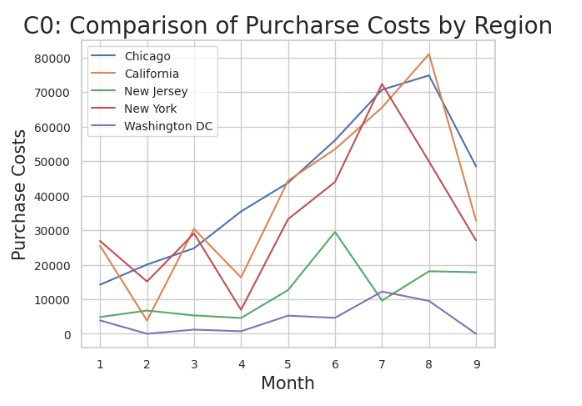

In [ ]:
images_code_Comparison_of_Purcharse_Cost_Rates_by_Region = "/content/drive/MyDrive/kdt-data-33/DS_DE_33/pjt-1/dacon-raw-data/월별구매금액.jpg"
image_code_Comparison_of_Purcharse_Cost_Rates_by_Region = cv2.imread(images_code_Comparison_of_Purcharse_Cost_Rates_by_Region)
cv2_imshow(image_code_Comparison_of_Purcharse_Cost_Rates_by_Region)

## 4-2 ) 재구매자율 표

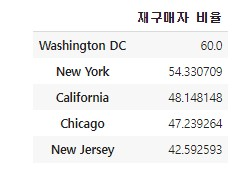

In [ ]:
images_code_repurchase_df = "/content/drive/MyDrive/kdt-data-33/DS_DE_33/pjt-1/dacon-raw-data/재구매자비율.jpg"
image_code_repurchase_df = cv2.imread(images_code_repurchase_df)
cv2_imshow(image_code_repurchase_df)

## 4-3) 구매율과 배송료 관계

In [ ]:
# 변수를 불러올 수 없으므로

# def c0_region_order(x):
#   mask = cluster_0['고객지역'] == x
#   data = cluster_0[mask]['거래ID'].nunique() / cluster_0['거래ID'].nunique() * 100
#   return round(data, 2)
# c0_region_order_ratio = [c0_region_order(region) for region in region_list]
# # c0_region_order_ratio_df = pd.DataFrame(c0_region_order_ratio, index=(region for region in region_list))

# def c0_region_delivery(x):
#   mask = cluster_0_total_price['고객지역'] == x
#   data = cluster_0_total_price[mask]['배송료'].sum() / cluster_0_total_price['배송료'].sum() * 100
#   return round(data, 2)

# c0_region_delivery_ratio = [c0_region_delivery(region) for region in region_list]
# # c0_region_delivery_ratio_df = pd.DataFrame(c0_region_delivery_ratio, index=(region for region in region_list))

# c0_order_delivery_df = pd.DataFrame({
#     '고객지역': region_list,
#     '거래횟수': c0_region_order_ratio,
#     '배송료': c0_region_delivery_ratio
# })
# c0_order_delivery_df

In [ ]:
# xlabel = region_list
# x = np.arange(len(xlabel))
# y1 = c0_region_order_ratio
# y2 = c0_region_delivery_ratio

# width = 0.35

# fig, axes = plt.subplots()
# axes.bar(x - width/2, y1, width, align='center', alpha=0.5)
# axes.bar(x + width/2, y2, width, align='center', alpha=0.8)

# plt.xticks(x, fontsize=10, rotation=45)
# plt.yticks(fontsize=10)
# axes.set_xticklabels(xlabel, fontsize=10)
# plt.xlabel("Region", fontsize=15)
# plt.ylabel("Rate", fontsize=15)
# plt.legend(["Transaction Frequency Rate","Delivery Fee Rate"], fontsize=10)
# plt.title('C0: Comparison of Rates by Region', fontsize=20)
# plt.show()

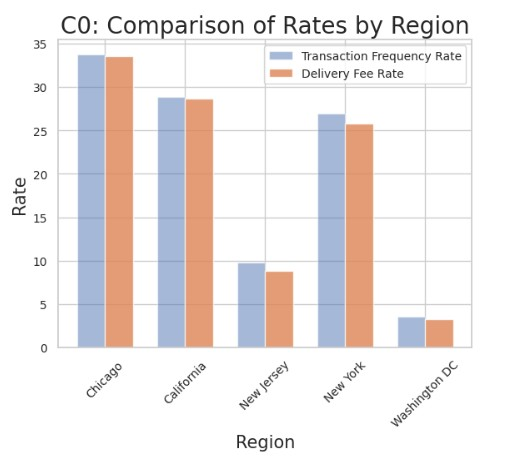

In [ ]:
images_code_delivery_cost = "/content/drive/MyDrive/kdt-data-33/DS_DE_33/pjt-1/dacon-raw-data/구매율과 배송료 관계.jpg"
image_code_delivery_cost = cv2.imread(images_code_delivery_cost)
cv2_imshow(image_code_delivery_cost)